# 构建信用卡反欺诈预测模型

## 本项目需解决的问题

本项目通过利用信用卡的历史交易数据，进行机器学习，构建信用卡反欺诈预测模型，提前发现客户**信用卡被盗刷**的事件。

## 建模思路

![1.jpg](./场景解析.jpg)

## 项目背景

数据集包含由欧洲持卡人于2013年9月使用信用卡进行交的数据。此数据集显示两天内发生的交易，其中284,807笔交易中有492笔被盗刷。数据集非常不平衡，
积极的类（被盗刷）占所有交易的0.172％。

它只包含作为PCA转换结果的数字输入变量。不幸的是，由于保密问题，我们无法提供有关数据的原始功能和更多背景信息。特征V1，V2，... V28是使用PCA
获得的主要组件，没有用PCA转换的唯一特征是“时间”和“量”。特征'时间'包含数据集中每个事务和第一个事务之间经过的秒数。特征“金额”是交易金额，此特
征可用于实例依赖的成本认知学习。特征'类'是响应变量，如果发生被盗刷，则取值1，否则为0。
以上取自Kaggle官网对本数据集部分介绍（谷歌翻译），关于数据集更多介绍请参考《[Credit Card Fraud Detection](https://link.zhihu.com/?target=https%3A//www.kaggle.com/dalpozz/creditcardfraud)》。

## 场景解析（算法选择）

1. 首先，我们拿到的数据是持卡人两天内的信用卡交易数据，这份数据包含很多维度，要解决的问题是预测持卡人是否会发生信用卡被盗刷。信用卡持卡人是否会发生被盗刷只有两种可能，发生被盗刷或不发生被盗刷。又因为这份数据是打标好的（字段Class是目标列），也就是说它是一个监督学习的场景。于是，我们判定信用卡持卡人是否会发生被盗刷是一个**二元分类**问题，意味着可以通过二分类相关的算法来找到具体的解决办法，本项目选用的算法是逻辑斯蒂回归（Logistic Regression）。
2. 分析数据：数据是结构化数据 ，不需要做特征抽象。特征V1至V28是经过PCA处理，而特征Time和Amount的数据规格与其他特征差别较大，需要对其做特征缩放，将特征缩放至同一个规格。在数据质量方面 ，没有出现乱码或空字符的数据，可以确定字段Class为目标列，其他列为特征列。
3. 这份数据是全部打标好的数据，可以通过交叉验证的方法对训练集生成的模型进行评估。70%的数据进行训练，30%的数据进行预测和评估。
&emsp&emsp**现对该业务场景进行总结如下：**
1. 根据历史记录数据学习并对信用卡持卡人是否会发生被盗刷进行预测，二分类监督学习场景，选择逻辑斯蒂回归（Logistic Regression）算法。
1. 数据为结构化数据，不需要做特征抽象，但需要做特征缩放。

# 1数据获取与解析

In [1]:
import numpy as np 
import pandas as pd

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('./creditcard.csv')
data.shape

(284807, 31)

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


从上面可以看出，数据为结构化数据，不需要抽特征转化，但特征Time和Amount的数据规格和其他特征不一样，需要对其做特征做特征缩放。

In [5]:
# 0表示没问题, 1表示被盗刷
data['Class'].unique()

array([0, 1], dtype=int64)

In [6]:
data['Time'].min()

0.0

In [7]:
data['Time'].max()

172792.0

In [8]:
data['Time'] = data['Time'].map(lambda x: divmod(x, 3600)[0])

In [9]:
data['Time'].min()

0.0

In [10]:
data['Amount'].min()

0.0

In [11]:
data['Amount'].max()

25691.16

In [12]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [13]:
# 特征缩放
from sklearn.preprocessing import StandardScaler

In [14]:
standardScaler = StandardScaler()

data[['Amount']] = standardScaler.fit_transform(data[['Amount']])

In [15]:
# Amout这一列和V1~V28 数量级上,不会太大差距
data['Amount']

0         0.244964
1        -0.342475
2         1.160686
3         0.140534
4        -0.073403
5        -0.338556
6        -0.333279
7        -0.190107
8         0.019392
9        -0.338516
10       -0.322044
11       -0.313289
12        0.132538
13       -0.243282
14       -0.118142
15       -0.289300
16       -0.301294
17       -0.349671
18       -0.166119
19       -0.333239
20        0.573167
21       -0.216935
22       -0.344114
23       -0.262273
24       -0.349671
25       -0.247560
26       -0.185790
27       -0.289260
28       -0.221293
29       -0.301294
            ...   
284777   -0.349231
284778   -0.033382
284779   -0.253277
284780   -0.233287
284781   -0.301254
284782   -0.301974
284783   -0.307411
284784   -0.193306
284785   -0.346073
284786   -0.317447
284787   -0.313289
284788   -0.337277
284789   -0.111345
284790   -0.314008
284791   -0.271988
284792   -0.337277
284793   -0.333279
284794   -0.349671
284795   -0.313768
284796   -0.113344
284797   -0.331280
284798   -0.

In [17]:
data[['Time']] = standardScaler.fit_transform(data[['Time']])

表明此数据有28万行，31列

说明数据类型只有float64和int64，且无缺失值，方便后续处理

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

# 2特征工程

### 样本均衡问题


![](2.jpg)

In [19]:
sample = data['Class'].value_counts()
sample

0    284315
1       492
Name: Class, dtype: int64

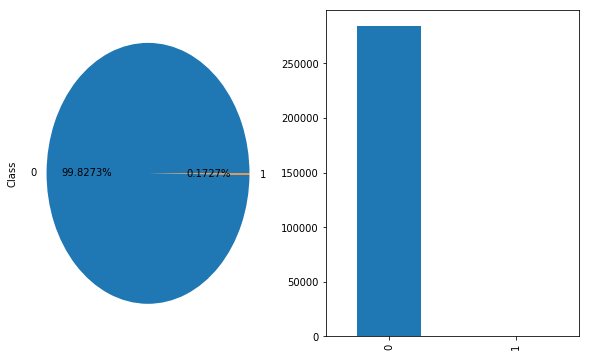

In [29]:
# sample Series, 可以直接画图
plt.figure(figsize=(10, 6))

axes = plt.subplot(1, 2, 1)

sample.plot(kind='pie', ax=axes, autopct='%0.4f%%')

axes = plt.subplot(1, 2, 2)

sample.plot(kind='bar', ax = axes)

通过上面的图和数据可知，存在492例盗刷，占总样本的0.17%，由此可知，这是一个明显的数据类别不平衡问题，稍后我们采用过采样(增加数据)的方法对这种问题进行处理。

## 特征转换,将时间从单位每秒化为单位每小时 
### 整除求余divmod

## 特征选择

![](3.jpg)

In [30]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

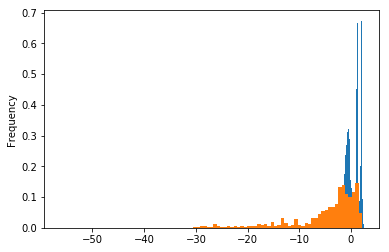

In [34]:
cond0 = data['Class'] == 0

cond1 = data['Class'] == 1

# normed 归一化
data['V1'][cond0].plot(kind='hist', bins=500, density=True)

data['V1'][cond1].plot(kind='hist', bins=50, density=True)

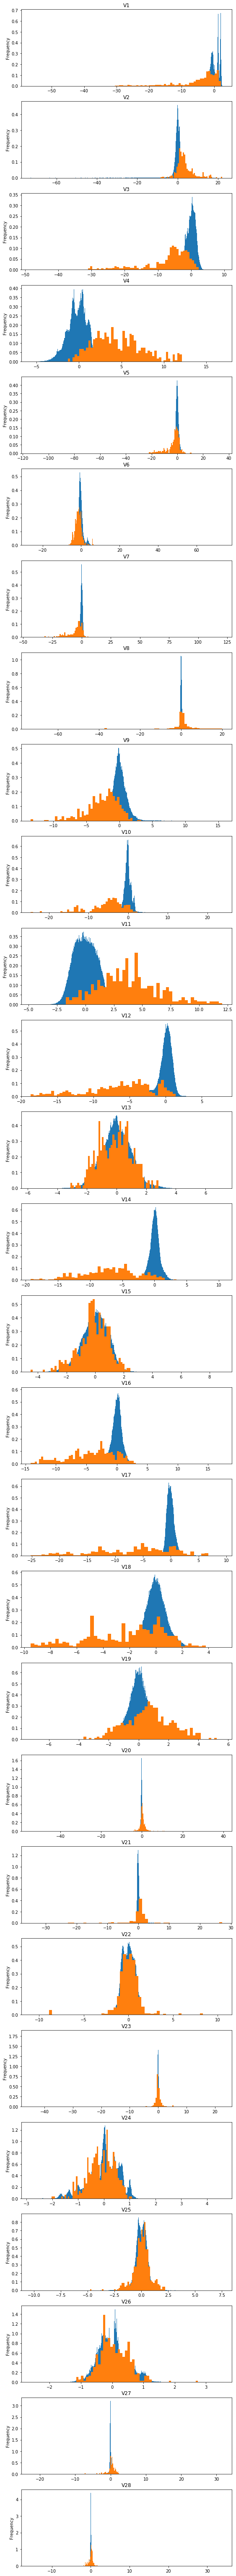

In [35]:
cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

cond0 = data['Class'] == 0

cond1 = data['Class'] == 1

plt.figure(figsize=(9, 28*4))

for i, col in enumerate(cols):
    
    axes = plt.subplot(28, 1, 1+i)
    # 特定一列取出来
    
    # 当前属性类别是0的所有数据
    data[col][cond0].plot(kind='hist', bins=500, density=True, ax=axes)
    
    # 当前属性类别是1的所有数据
    data[col][cond1].plot(kind='hist', bins=50, density=True, ax=axes)
    
    axes.set_title(col)

In [36]:
drops = ['V5', 'V6', 'V7', 'V8', 'V13', 'V15', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

data2 = data.drop(labels=drops, axis=1)

In [38]:
data2.head()

,Time,V1,V2,V3,V4,V9,V10,V11,V12,V14,V16,V17,V18,V19,Amount,Class
0,-1.960264,-1.359807,-0.072781,2.536347,1.378155,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,0.244964,0
1,-1.960264,1.191857,0.266151,0.166480,0.448154,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.342475,0
2,-1.960264,-1.358354,-1.340163,1.773209,0.379780,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,1.160686,0
3,-1.960264,-0.966272,-0.185226,1.792993,-0.863291,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,0.140534,0
4,-1.960264,-1.158233,0.877737,1.548718,0.403034,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.073403,0


上图是不同变量在信用卡被盗刷和信用卡正常的不同分布情况，我们将选择在不同信用卡状态下的分布有明显区别的变量。因此剔除变量V8、V13 、V15 、V20
、V21 、V22、 V23 、V24 、V25 、V26 、V27 和V28变量。

## 特征缩放

Amount变量和Time变量的取值范围与其他变量相差较大，所以要对其进行特征缩放  
sklearn.preprocessing.StandarScaler

## 对特征的重要性进行排序，以进一步减少变量  
### 利用GBDT梯度提升决策树进行特征重要性排序

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [40]:
X = data2.iloc[:, : -1]

y = data2['Class']

In [41]:
gbdt = GradientBoostingClassifier()

gbdt.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [42]:
# 重要性
gbdt.feature_importances_

array([0.03055754, 0.        , 0.        , 0.09660516, 0.09414724,
       0.01620504, 0.05287026, 0.47141206, 0.01602952, 0.09903794,
       0.00174375, 0.07515133, 0.0303451 , 0.01589505, 0.        ])

In [45]:
# 重要性从大到小排序
index = gbdt.feature_importances_.argsort()[::-1]
index

array([ 7,  9,  3,  4, 11,  6,  0, 12,  5,  8, 13, 10, 14,  2,  1],
      dtype=int64)

In [46]:
index.size

15

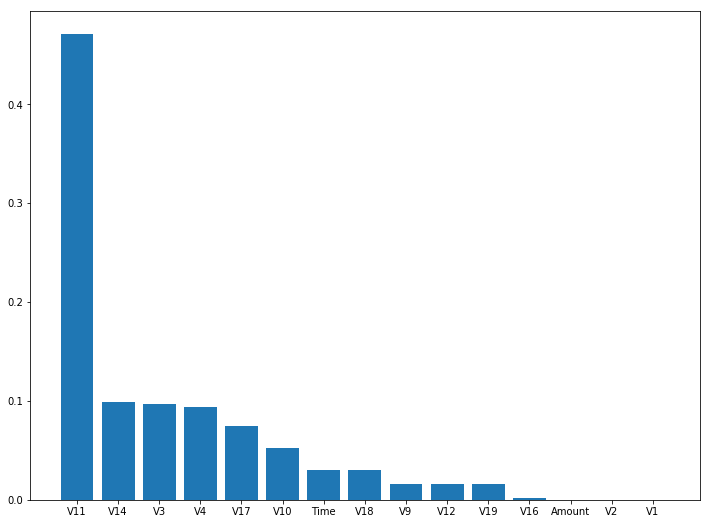

In [50]:
plt.figure(figsize=(12, 9))
plt.bar(np.arange(15), gbdt.feature_importances_[index])

_ = plt.xticks(np.arange(15), data2.columns[index])

In [52]:
drops = ['V16', 'Amount', 'V2', 'V1']

data3 = data2.drop(labels=drops, axis=1)
data3.head()

,Time,V3,V4,V9,V10,V11,V12,V14,V17,V18,V19,Class
0,-1.960264,2.536347,1.378155,0.363787,0.090794,-0.551600,-0.617801,-0.311169,0.207971,0.025791,0.403993,0
1,-1.960264,0.166480,0.448154,-0.255425,-0.166974,1.612727,1.065235,-0.143772,-0.114805,-0.183361,-0.145783,0
2,-1.960264,1.773209,0.379780,-1.514654,0.207643,0.624501,0.066084,-0.165946,1.109969,-0.121359,-2.261857,0
3,-1.960264,1.792993,-0.863291,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-0.684093,1.965775,-1.232622,0
4,-1.960264,1.548718,0.403034,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.237033,-0.038195,0.803487,0


# 模型训练
**处理样本不平衡问题**

目标变量“Class”正常和被盗刷两种类别的数量差别较大，会对模型学习造成困扰。举例来说，假如有100个样本，其中只有1个是被盗刷样本，其余99个全为正常样本，那么学习器只要制定一个简单的方法：即判别所有样本均为正常样本，就能轻松达到99%的准确率。而这个分类器的决策对我们的风险控制毫无意义。因此，在将数据代入模型训练之前，我们必须先解决样本不平衡的问题。
**现对该业务场景进行总结如下：**
1. 过采样（oversampling），增加正样本使得正、负样本数目接近，然后再进行学习。
2. 欠采样（undersampling），去除一些负样本使得正、负样本数目接近，然后再进行学习。
本次处理样本不平衡采用的方法是**过采样**，具体操作使用SMOTE（Synthetic Minority Oversampling Technique），SMOET的基本原理是：采样最邻近算法，计算出每个少数类样本的K个近邻，从K个近邻中随机挑选N个样本进行随机线性插值，构造新的少数样本，同时将新样本与原数据合成，产生新的训练集。更详细说明参考CMU关于SMOTE: [Synthetic Minority Over-sampling Technique](http://link.zhihu.com/?target=http%3A//www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/chawla2002.html)的介绍。

In [53]:
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

In [54]:
X = data3.iloc[: , : -1]

y = data3['Class']

In [55]:
X.head()

,Time,V3,V4,V9,V10,V11,V12,V14,V17,V18,V19
0,-1.960264,2.536347,1.378155,0.363787,0.090794,-0.551600,-0.617801,-0.311169,0.207971,0.025791,0.403993
1,-1.960264,0.166480,0.448154,-0.255425,-0.166974,1.612727,1.065235,-0.143772,-0.114805,-0.183361,-0.145783
2,-1.960264,1.773209,0.379780,-1.514654,0.207643,0.624501,0.066084,-0.165946,1.109969,-0.121359,-2.261857
3,-1.960264,1.792993,-0.863291,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-0.684093,1.965775,-1.232622
4,-1.960264,1.548718,0.403034,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.237033,-0.038195,0.803487


In [56]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [59]:
# 训练数据是否均衡

y_train.value_counts()

0    227454
1       391
Name: Class, dtype: int64

In [60]:
smote = SMOTE()

X_train2, y_train2 = smote.fit_sample(X_train, y_train)

In [62]:
# 查看训练数据是否均衡
(y_train2 == 0).sum()

227454

In [63]:
(y_train2 == 1).sum()

227454

# SMOTE过采样

# 自定义可视化函数

In [73]:
# for 循环
import itertools
# 画图方法
# 绘制真实值和预测值对比情况
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")#若对应格子上面的数量不超过阈值则，上面的字体为白色，为了方便查看

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 单独的逻辑回归求得查全率Recall rate  
# Recall也叫召回率


In [64]:
from sklearn.linear_model import LogisticRegression

In [65]:
logistic = LogisticRegression()

logistic.fit(X_train2, y_train2)

# y_是算法预测的数据, 真是的数据y_test
y_ = logistic.predict(X_test)

H:\env\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [71]:
from sklearn.metrics import confusion_matrix

In [67]:
cm = confusion_matrix(y_test, y_)
cm

array([[55528,  1333],
       [    8,    93]], dtype=int64)

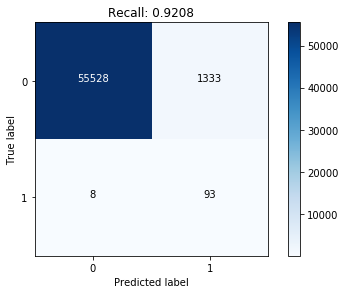

In [74]:
plot_confusion_matrix(cm, classes=[0, 1], title='Recall: %0.4f'%(cm[1, 1]/(cm[1, 1]+cm[1, 0])))

# 利用GridSearchCV进行交叉验证和模型参数自动调优

In [75]:
from sklearn.model_selection import GridSearchCV

In [76]:
from sklearn.model_selection import KFold, StratifiedKFold

In [77]:
logistic = LogisticRegression()

clf = GridSearchCV(logistic, param_grid={'C':[0.1, 1, 10, 100]}, cv=10)

clf.fit(X_train2, y_train2)

y_ = clf.predict(X_test)

H:\env\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
H:\env\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
H:\env\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
H:\env\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
H:\env\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
H:\env\ana

# 预测

In [78]:
clf.score(X_test, y_test)

0.9764579895368842

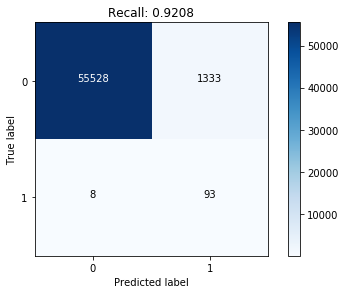

In [79]:
cm = confusion_matrix(y_test, y_)

plot_confusion_matrix(cm, classes=[0, 1], title='Recall: %0.4f'%(cm[1, 1]/(cm[1, 1]+cm[1, 0])))

# 结果可视化  
## 对比逻辑斯蒂回归和GridSearchCV结果

# 模型评估

解决不同的问题，通常需要不同的指标来度量模型的性能。例如我们希望用算法来预测癌症是否是恶性的，假设100个病人中有5个病人的癌症是恶性，
对于医生来说，尽可能提高模型的**查全率（recall）比提高查准率（precision）**更为重要，因为站在病人的角度，**发生漏发现癌症为恶性比发生误
判为癌症是恶性更为严重。**

由此可见就上面的两个算法而言，明显lgb过拟合了，考虑到样本不均衡问题，故应该选用简单一点的算法（逻辑回归）来减少陷入过拟合的陷阱。

## 考虑设置阈值，来调整预测被盗刷的概率，依次来调整模型的查全率（Recall）

In [80]:
thresholds = np.arange(0, 1, step=0.05)

y_proba_ = clf.predict_proba(X_test)[:, 1]
y_proba_

array([0.04959194, 0.03070296, 0.03135502, ..., 0.03641235, 0.26902147,
       0.05518279])

In [81]:
from sklearn.metrics import auc, roc_curve

In [83]:
recalls = []

accuracies = []

aucs = []

cms = []

for threshold in thresholds:
    
    # 概率转化为类别
    y_ = (y_proba_ >= threshold).astype(np.int8)
    
    # 真实值y_test
    cm = confusion_matrix(y_test, y_)
    
    cms.append(cm)
    
    # 召回率, 准确率, auc
    recalls.append(cm[1, 1]/(cm[1, 1]+cm[1, 0]))
    
    # 准确率
    accuracies.append((cm[0, 0]+cm[1, 1])/cm.sum())
    
    # auc
    fpr, tpr, ths = roc_curve(y_test, y_proba_)
    
    aucs.append(auc(fpr, tpr))

In [84]:
# 不同的阈值,recall怎样变化

thresholds.size

20

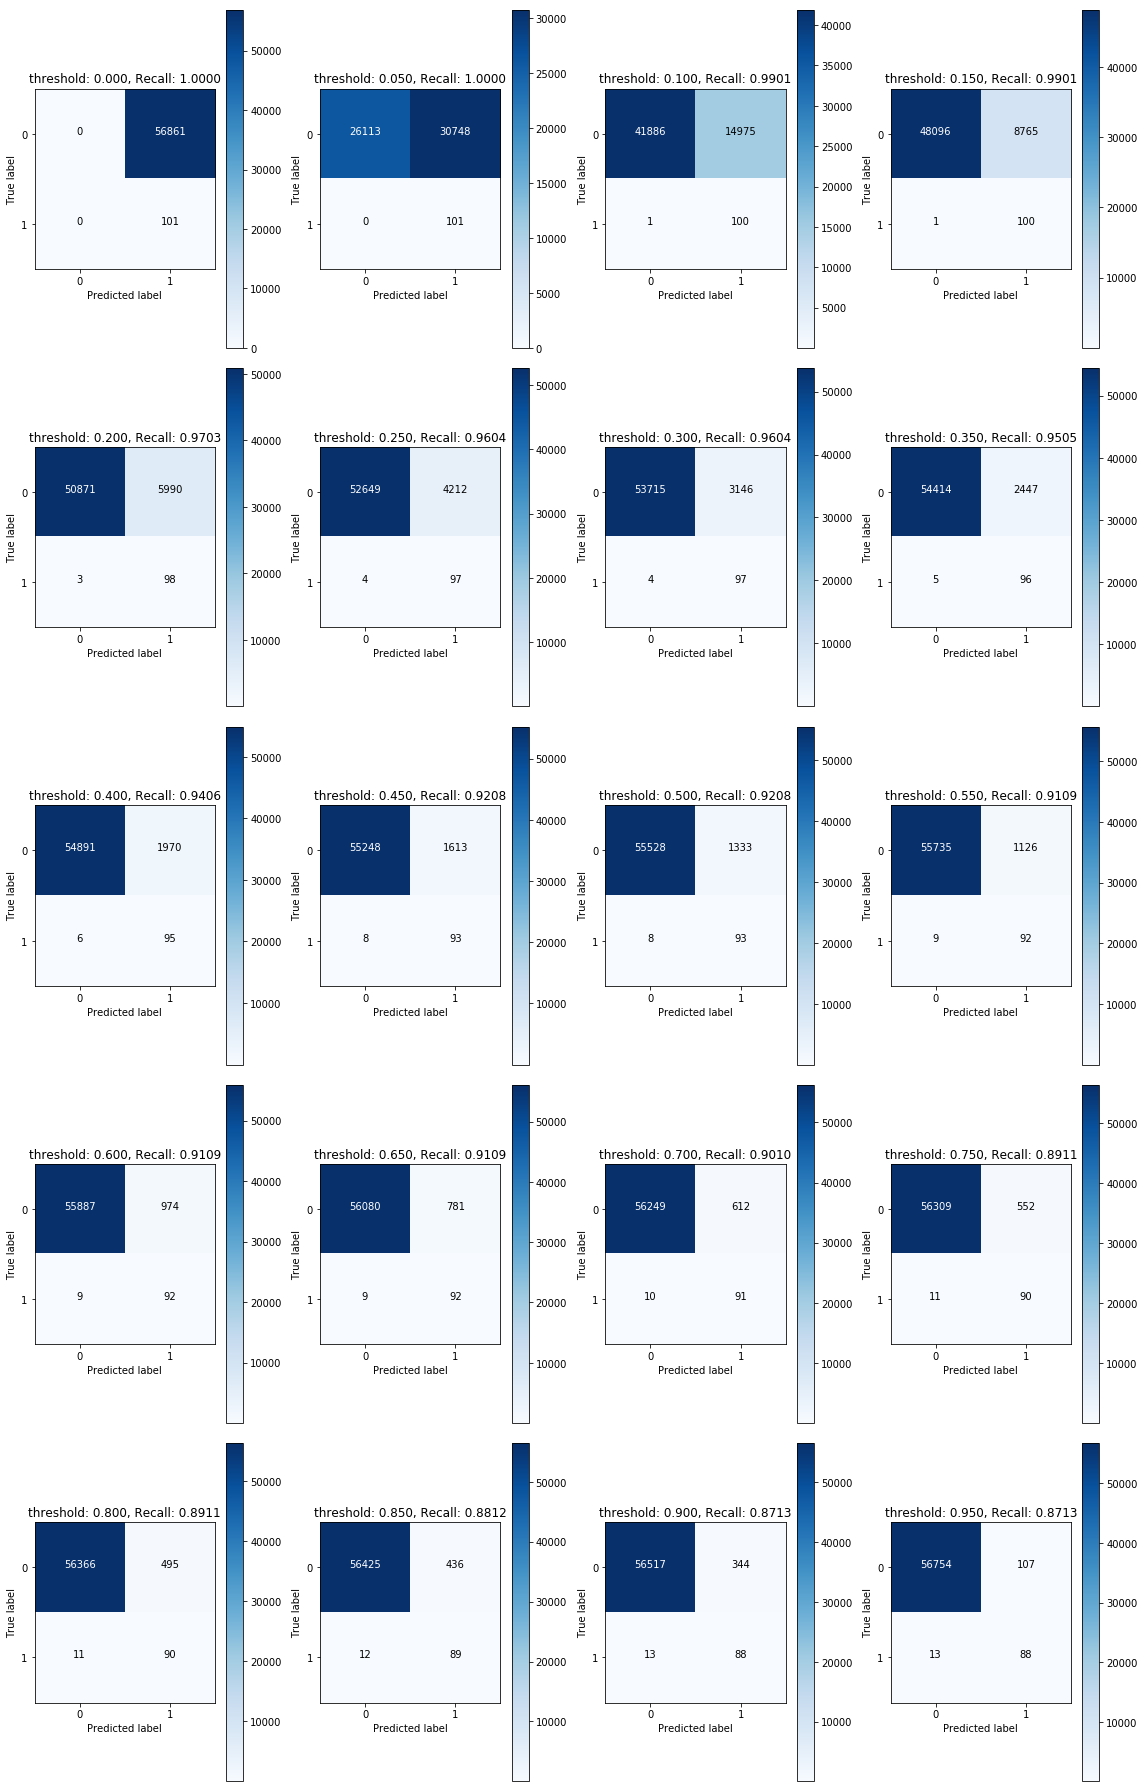

In [85]:
plt.figure(figsize=(4*4, 5*5))
for i in range(20):
    
    axes = plt.subplot(5, 4, i+1)
    
    plot_confusion_matrix(cms[i], classes=[0, 1], title='threshold: %0.3f, Recall: %0.4f'%(thresholds[i], recalls[i]))

# 趋势图

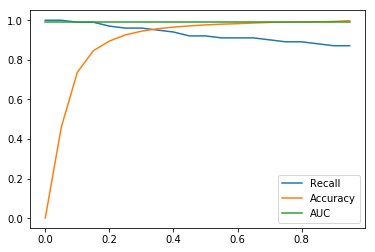

In [86]:
plt.plot(thresholds, recalls, label='Recall')

plt.plot(thresholds, accuracies, label='Accuracy')

plt.plot(thresholds, aucs, label='AUC')

plt.legend()

由上图所见，随着阈值逐渐变大，Recall rate逐渐变小，Precision rate逐渐变大，AUC值先增后减

# 找出模型最优的阈值

precision和recall是一组矛盾的变量。从上面混淆矩阵和PRC曲线可以看到，阈值越小，recall值越大，模型能找出信用卡被盗刷的数量也就更多，但换来的代价是误判的数量也较大。随着阈值的提高，recall值逐渐降低，precision值也逐渐提高，误判的数量也随之减少。**通过调整模型阈值，控制模型反信用卡欺诈的力度，若想找出更多的信用卡被盗刷就设置较小的阈值，反之，则设置较大的阈值。**
实际业务中，阈值的选择取决于公司业务边际利润和边际成本的比较；当模型阈值设置较小的值，确实能找出更多的信用卡被盗刷的持卡人，但随着误判数量增加，不仅加大了贷后团队的工作量，也会降低正常情况误判为信用卡被盗刷客户的消费体验，从而导致客户满意度下降，如果某个模型阈值能让业务的**边际利润和边际成本达到平衡时，则该模型的阈值为最优值**。当然也有例外的情况，发生金融危机，往往伴随着贷款违约或信用卡被盗刷的几率会增大，而金融机构会更愿意设置小阈值，不惜一切代价守住风险的底线。